In [10]:
import os, random
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

from pycocotools.coco import COCO

COCO_ROOT = "data/coco"
IMG_DIR = os.path.join(COCO_ROOT, "val2017")
ANNOTATIONS_PATH = os.path.join(COCO_ROOT, "annotations", "instances_val2017.json")

coco = COCO(ANNOTATIONS_PATH) # [x, y, width, height]

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


In [11]:
# Define small object
SMALL_THRESHOLD = 0.01
MEDIUM_THRESHOLD = 0.05

def size_group(bbox_area, img_area):
    r = bbox_area / img_area
    if r < SMALL_THRESHOLD:
        return "small"
    elif r < MEDIUM_THRESHOLD:
        return "medium"
    else:
        return "large"

In [12]:
target_names = {"person", "car", "truck", "bus", "bicycle", "motorcycle"}

# Mapping: category_id -> category_name
# cocoAPI -> cat: category, img: image, ann: annotation
cats = coco.loadCats(coco.getCatIds())
cat_id_to_name = {c["id"]: c["name"] for c in cats}

target_cat_ids = [cid for cid, name in cat_id_to_name.items() if name in target_names]

print("Target category IDs:", target_cat_ids)
print("Target category names: ", [cat_id_to_name[cid] for cid in target_cat_ids])

Target category IDs: [1, 2, 3, 4, 6, 8]
Target category names:  ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'truck']


In [13]:
# Export annotations that matches the target categories

ann_ids = coco.getAnnIds(catIds=target_cat_ids)
print("Total target annotations number: ", len(ann_ids))

samples = []

for ann_id in tqdm(ann_ids):
    ann = coco.loadAnns(ann_id)[0]
    img = coco.loadImgs(ann["image_id"])[0]

    x, y, w, h = ann["bbox"]
    if w <= 1. or h <= 1:
        continue

    img_w, img_h = img["width"], img["height"]
    img_area = img_w * img_h
    bbox_area = w * h

    sg_ratio = size_group(bbox_area, img_area)

    samples.append({
        "image_id": img["id"],
        "file_name": img["file_name"],
        "image_path": os.path.join(IMG_DIR, img["file_name"]),
        "ann_id": ann_id,

        "category_id": ann["category_id"],
        "category_name": cat_id_to_name[ann["category_id"]],

        "bbox_x": x, "bbox_y": y, "bbox_w": w, "bbox_h": h,
        "bbox_area": bbox_area,
        "img_area": img_area,
        "area_ratio": bbox_area / img_area,
        "size_group": sg_ratio,
    })

df = pd.DataFrame(samples)

print(df.shape)
print(df["size_group"].value_counts())
print(df["category_name"].value_counts().head(20))

Total target annotations number:  14323


100%|██████████| 14323/14323 [00:00<00:00, 544246.49it/s]

(14323, 14)
size_group
small     6662
large     4169
medium    3492
Name: count, dtype: int64
category_name
person        11004
car            1932
truck           415
motorcycle      371
bicycle         316
bus             285
Name: count, dtype: int64


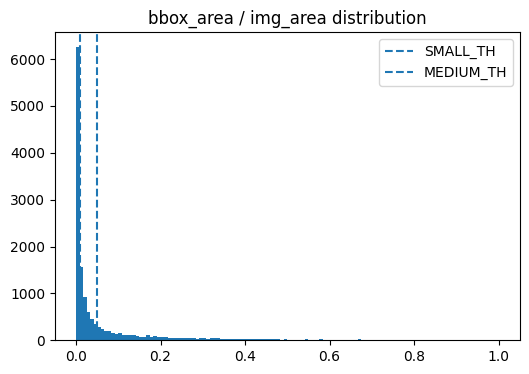

category_name  bicycle  bus   car  motorcycle  person  truck
size_group                                                  
large               70  168   202         172    3425    132
medium              94   55   365         102    2755    121
small              152   62  1365          97    4824    162

In [15]:
# Plot distribution of bbox area ratio to check thresholds
plt.figure(figsize=(6,4))
plt.hist(df["area_ratio"], bins=120)
plt.axvline(SMALL_THRESHOLD, linestyle="--", label="SMALL_TH")
plt.axvline(MEDIUM_THRESHOLD, linestyle="--", label="MEDIUM_TH")
plt.legend()
plt.title("bbox_area / img_area distribution")
plt.show()

# Count by size_group x category_name
df.groupby(["size_group", "category_name"]).size().unstack(fill_value=0)


In [16]:
def sample_group(custom_df, group, n):
    sub = custom_df[custom_df["size_group"] == group]
    return sub.sample(min(n, len(sub)), random_state=42)

NUMBER_PER_GROUP = 200

df_small = sample_group(df, "small", NUMBER_PER_GROUP)
df_medium = sample_group(df, "medium", NUMBER_PER_GROUP)
df_large = sample_group(df, "large", NUMBER_PER_GROUP)

df_sub = pd.concat([df_small, df_medium, df_large], ignore_index=True)

print("Final sampled rows:", len(df_sub))
print(df_sub["size_group"].value_counts())
print(df_sub["category_name"].value_counts())

Final sampled rows: 600
size_group
small     200
medium    200
large     200
Name: count, dtype: int64
category_name
person        439
car            90
bus            25
motorcycle     18
truck          15
bicycle        13
Name: count, dtype: int64


Category 'person' has too much influence on the whole dataset, so it should be controlled setting up a limit.

In [18]:
# Since category 'person' has too much portion, define new function that limits category 'person'
def sample_group_with_person_limit(custom_df, group, n, person_limit=70):
    sub = custom_df[custom_df["size_group"] == group]

    persons = sub[sub["category_name"] == "person"]
    others = sub[sub["category_name"] != "person"]

    persons = persons.sample(min(person_limit, len(persons)), random_state=42)

    remaining = n - len(persons)
    others = others.sample(min(remaining, len(others)), random_state=42)

    return pd.concat([persons, others], ignore_index=True)

NUMBER_PER_GROUP = 200

df_small = sample_group_with_person_limit(df, "small", NUMBER_PER_GROUP)
df_medium = sample_group_with_person_limit(df, "medium", NUMBER_PER_GROUP)
df_large = sample_group_with_person_limit(df, "large", NUMBER_PER_GROUP)

df_sub = pd.concat([df_small, df_medium, df_large], ignore_index=True)

print(df_sub["size_group"].value_counts())
print(df_sub["category_name"].value_counts())

size_group
small     200
medium    200
large     200
Name: count, dtype: int64
category_name
person        210
car           190
motorcycle     72
truck          53
bus            44
bicycle        31
Name: count, dtype: int64


Now the category 'person' doesn't dominate the dataset

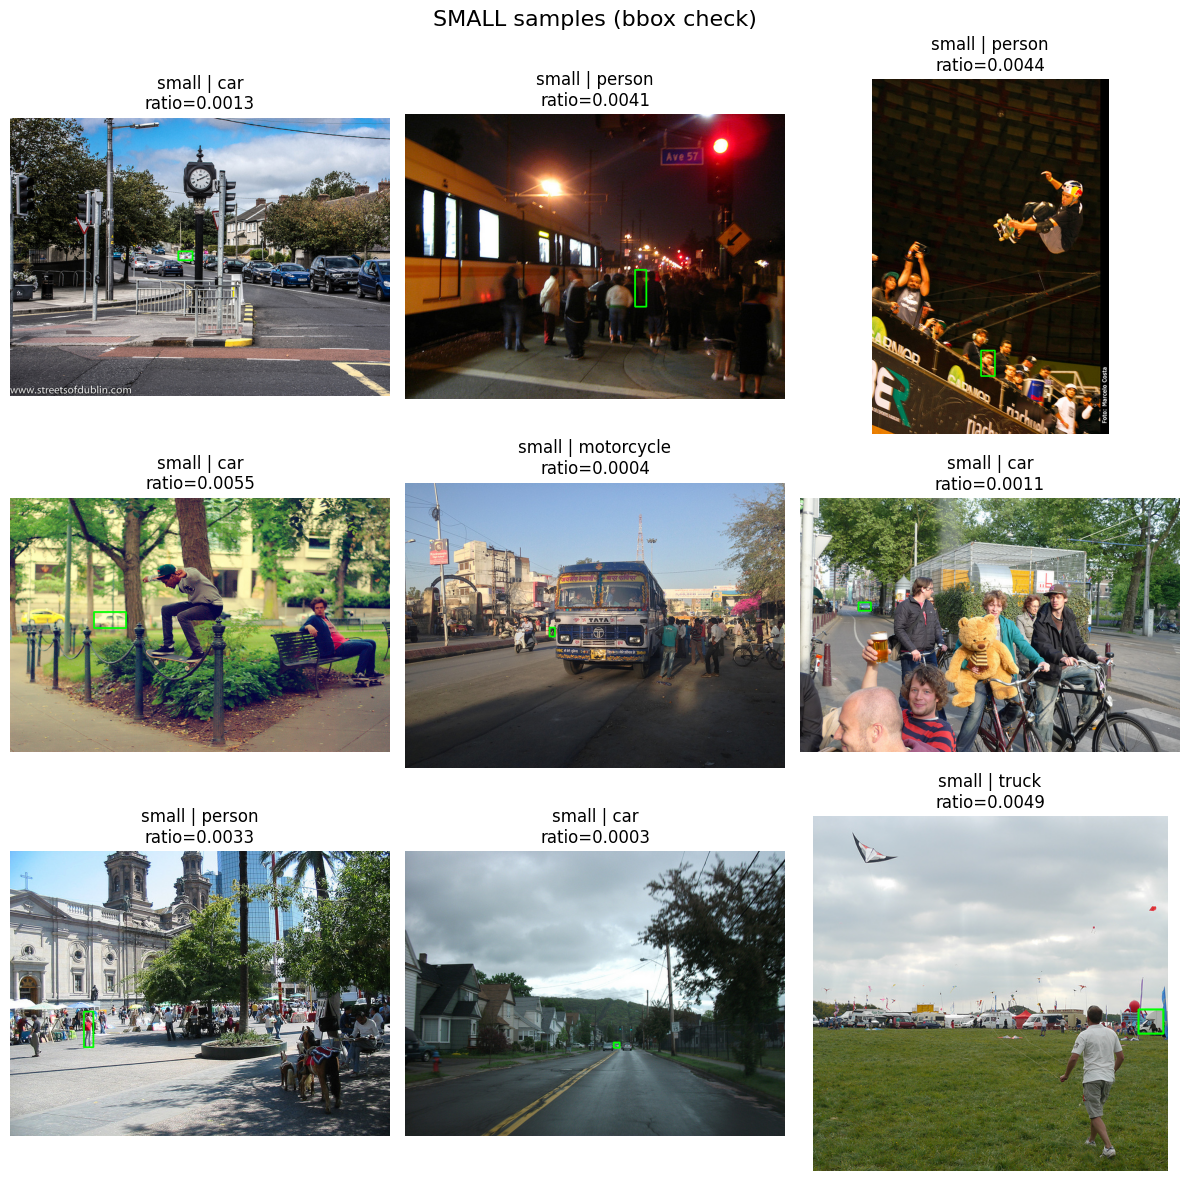

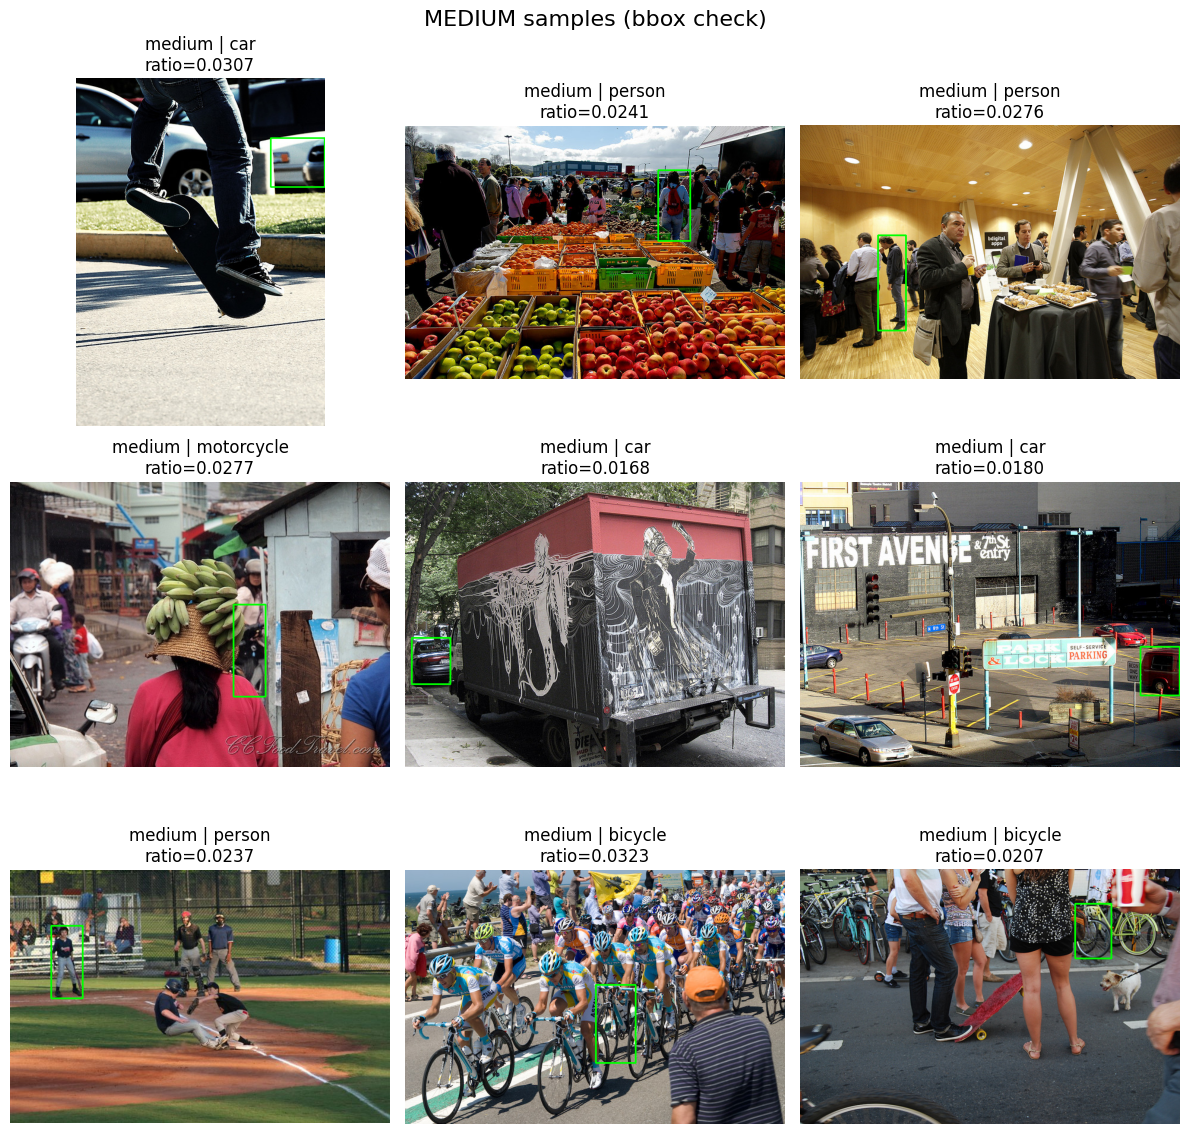

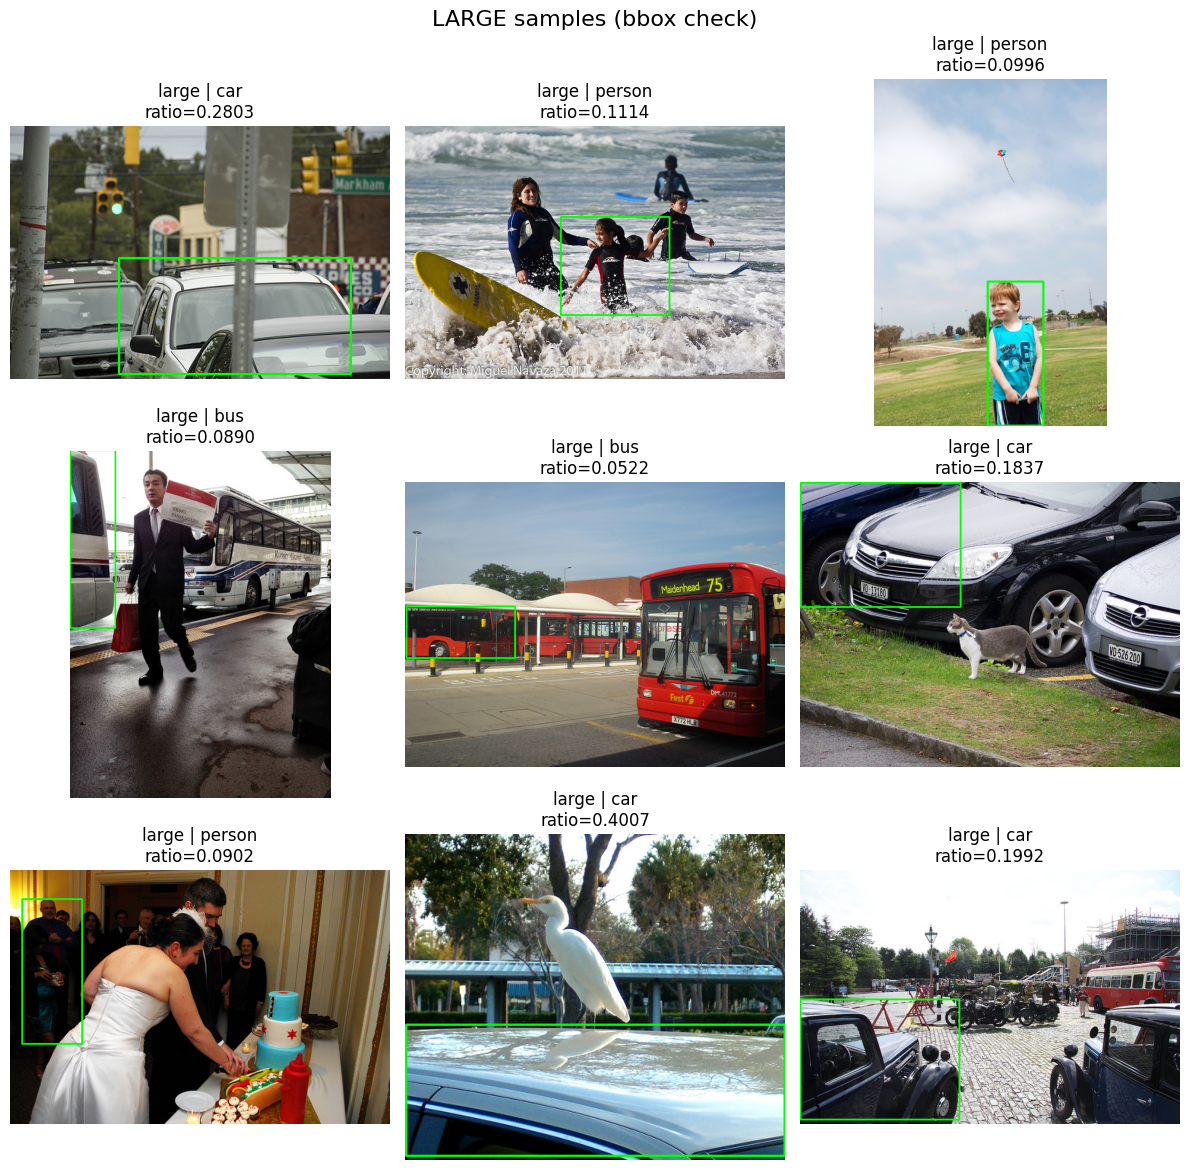

In [22]:
def draw_bbox_rgb(img_rgb, row, color=(0, 255, 0), thickness=2):
    x = int(row["bbox_x"])
    y = int(row["bbox_y"])
    w = int(row["bbox_w"])
    h = int(row["bbox_h"])

    out = img_rgb.copy()
    cv2.rectangle(out, (x, y), (x + w, y + h), color, thickness)
    return out

def show_examples(custom_df, n=6, title="Examples"):
    if len(custom_df) == 0:
        print("No samples")
        return
    
    n = min(n, len(custom_df))
    sampled = custom_df.sample(n=n, random_state=42)

    cols = 3
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(12, 4 * rows))

    for i, (_, r) in enumerate(sampled.iterrows()):
        img_path = r["image_path"]

        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        out = draw_bbox_rgb(img_rgb, r)

        plt.subplot(rows, cols, i+1)
        plt.imshow(out)
        plt.axis("off")

        plt.title(
            f'{r["size_group"]} | {r["category_name"]}\n'
            f'ratio={r["area_ratio"]:.4f}'
        )
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

show_examples(df_sub[df_sub["size_group"] == "small"],  n=9, title="SMALL samples (bbox check)")
show_examples(df_sub[df_sub["size_group"] == "medium"], n=9, title="MEDIUM samples (bbox check)")
show_examples(df_sub[df_sub["size_group"] == "large"],  n=9, title="LARGE samples (bbox check)")

From the visual inspection, the size_based grouping works as intended.

Objects labeled as small are truly small in the image context and often appear far from the camera or surrounded by complex backgrounds. These objects are easy for humans to notice but likely challenging for CNNs due to limited pixel information.

The medium group contains objects that are clearly visible but do not dominate the image. They still include background clutter and partial occlusion, which can cause ambiguity during recognition.

In contrast, large objects occupy a significant portion of the image and are visually prominent. These cases are expected to be easier for CNNs to recognize and serve as a strong baseline for comparision.

In [25]:
OUT_DIR = "data"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_CSV = os.path.join(OUT_DIR, "samples_step1_person_limited.csv")

df_sub.to_csv(OUT_CSV, index=False)

print("Saved CSV:", OUT_CSV)
print("Rows:", len(df_sub))
print(df_sub["size_group"].value_counts())
print(df_sub["category_name"].value_counts())

Saved CSV: data/samples_step1_person_limited.csv
Rows: 600
size_group
small     200
medium    200
large     200
Name: count, dtype: int64
category_name
person        210
car           190
motorcycle     72
truck          53
bus            44
bicycle        31
Name: count, dtype: int64
